In [0]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [7]:
# Upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
# Download ocular disease recognition dataset
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k

100% 1.25G/1.26G [00:09<00:00, 160MB/s]
100% 1.26G/1.26G [00:09<00:00, 142MB/s]


In [0]:
# Extract the data
import zipfile
zip_ref = zipfile.ZipFile('ocular-disease-recognition-odir5k.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

# Import packages

In [132]:
import pandas as pd
import numpy as np
import os
import matplotlib.style as style
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
from time import time
import random
from keras.preprocessing import image

Using TensorFlow backend.


# Read data input

In [0]:
df = pd.read_excel('/content/files/ODIR-5K/data.xlsx')

In [13]:
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


# Create unique keywords for each label

In [0]:
leftEyeKeywords = df['Left-Diagnostic Keywords'].copy()
rightEyeKeywords = df['Right-Diagnostic Keywords'].copy()

In [0]:
leftEyeKeywords = leftEyeKeywords.str.split("，")
rightEyeKeywords = rightEyeKeywords.str.split("，")

In [16]:
leftEyeKeywords[2]

['laser spot', 'moderate non proliferative retinopathy']

In [17]:
# Retrieve unique keywords from left and right diagnostic keywords

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

res = pd.DataFrame(mlb.fit_transform(rightEyeKeywords),
                   columns=mlb.classes_,
                   index=rightEyeKeywords.index)

allDiagnosisLeft = res.columns.to_list()
len(allDiagnosisLeft)

res = pd.DataFrame(mlb.fit_transform(leftEyeKeywords),
                   columns=mlb.classes_,
                   index=leftEyeKeywords.index)

allDiagnosisRight = res.columns.to_list()
len(allDiagnosisRight)

allDiagnosis=list(set(allDiagnosisLeft+allDiagnosisRight))
print("total different keys diagnosis :", len(allDiagnosis))

total different keys diagnosis : 105


In [0]:
# Create a function to sort all keywords into label keywords
# and list row that contains multiple label

test_df = df.copy()
doubleDiagnosisRow = []

def getKeyDiagnosisSingle(colName):
  keyDiagnosis = []
  global doubleDiagnosisRow
  store = True
  for row in range(len(test_df[colName])):
    store = True
    if test_df[colName][row] == 1:
      for lable in test_df.columns[7:]:
        if lable == colName:
          continue
        if test_df[lable][row] == 1:
          doubleDiagnosisRow.append(row)
          store = False
          break
        
      if store == True:
        for i in rightEyeKeywords[row]:
          keyDiagnosis.append(i)
        for i in leftEyeKeywords[row]:
          keyDiagnosis.append(i)
      

  keyDiagnosis = list(set(keyDiagnosis))
  return keyDiagnosis

In [19]:
keyNormal = getKeyDiagnosisSingle(test_df.columns[7])
keyDiabetes = getKeyDiagnosisSingle(test_df.columns[8])
keyGlaucoma = getKeyDiagnosisSingle(test_df.columns[9])
keyCataract = getKeyDiagnosisSingle(test_df.columns[10])
keyAMD = getKeyDiagnosisSingle(test_df.columns[11])
keyHypertension = getKeyDiagnosisSingle(test_df.columns[12])
keyMyopia = getKeyDiagnosisSingle(test_df.columns[13])
keyOtherDisease = getKeyDiagnosisSingle(test_df.columns[14])

labelString = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Abnormalities']
keyAll = [keyNormal, keyDiabetes, keyGlaucoma, keyCataract, keyAMD, keyHypertension, keyMyopia, keyOtherDisease]

for i in range(8):
  print(labelString[i], len(keyAll[i]))

keyNormal

Normal 3
Diabetes 10
Glaucoma 5
Cataract 3
AMD 3
Hypertension 1
Myopia 6
Abnormalities 57


['normal fundus', 'low image quality', 'lens dust']

In [20]:
# Create permutations of 2 samples from 7 labels
from itertools import permutations

comb = list(permutations(range(1, 8), 2))
comb

[(1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (2, 1),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (3, 1),
 (3, 2),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 5),
 (4, 6),
 (4, 7),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 6),
 (5, 7),
 (6, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 5),
 (6, 7),
 (7, 1),
 (7, 2),
 (7, 3),
 (7, 4),
 (7, 5),
 (7, 6)]

In [21]:
# Intersect each label keyword with normal keyword
print("intersect by normal :\n")
for i in range(1,len(keyAll)):
  keyAll[i] = list(set(keyAll[i])-set(keyAll[0]))

for i in range(8):
  print(labelString[i], len(keyAll[i]))

intersect by normal :

Normal 3
Diabetes 8
Glaucoma 3
Cataract 1
AMD 2
Hypertension 1
Myopia 4
Abnormalities 54


In [22]:
# Intersect each label with each other except normal keywords
print("\nintersect by others :\n")
for i in range(len(keyAll)-1):
  for j in range(6):
    k = j+6*i
    keyAll[i+1] = list(set(keyAll[i+1])-set(keyAll[comb[k][1]]))

for i in range(8):
  print(labelString[i], len(keyAll[i]))


intersect by others :

Normal 3
Diabetes 7
Glaucoma 3
Cataract 1
AMD 2
Hypertension 1
Myopia 4
Abnormalities 54


In [0]:
# Create a function to calculate total unique keywords from all label keywords

def getAllRecognizedKey(mkeyAll):
  mallkeyDiagnosis = []
  for i in range(len(mkeyAll)):
    mkeyAll[i] = list(set(mkeyAll[i]))
    mallkeyDiagnosis = mallkeyDiagnosis+list(set(mkeyAll[i]))
  return mallkeyDiagnosis

In [24]:
keyNormal, keyDiabetes, keyGlaucoma, keyCataract, keyAMD, keyHypertension, keyMyopia, keyOtherDisease = keyAll[0], keyAll[1], keyAll[2], keyAll[3], keyAll[4], keyAll[5], keyAll[6], keyAll[7]

allkeyDiagnosis = getAllRecognizedKey(keyAll)
len(allkeyDiagnosis)

75

In [25]:
# Check the number of row that contains multiple label then sort it

doubleDiagnosisRow = list(set(doubleDiagnosisRow))
print("double label row ",len(doubleDiagnosisRow))
doubleDiagnosisRow.sort()

double label row  586


In [26]:
# Find keyword that has not been included in any of label keywords

notlisted = []
listed = False
for row in doubleDiagnosisRow:
  # print(row)
  for ilist in leftEyeKeywords[row]:
    # print(ilist)
    listed = False
    for j in keyAll:
      if ilist in j:
        listed = True
        break
    if listed == False:
      notlisted.append(ilist)

for row in doubleDiagnosisRow:
  for ilist in rightEyeKeywords[row]:
    listed = False
    for j in keyAll:
      if ilist in j:
        listed = True
        break
    if listed == False:
      notlisted.append(ilist)

notlisted = list(set(notlisted))
# notlisted
print("not listed diagnosis key :",len(notlisted))

not listed diagnosis key : 30


In [0]:
# Create a function to separate keyword from multiple label row

def intersectFromMultiLabel(mkeyAll):
  mnotRecognizedList = []
  mallkeyDiagnosis = []
  for i in range(len(mkeyAll)):
    mkeyAll[i] = list(set(mkeyAll[i]))
    mallkeyDiagnosis = mallkeyDiagnosis+list(set(mkeyAll[i])) 
  for row in doubleDiagnosisRow:
    notlistedList = []
    listedList = []
    colIndex = []
    ind = []
    tempList = []
    for ilist in leftEyeKeywords[row]:
      if ilist not in mallkeyDiagnosis:
        tempList.append(ilist)
    for ilist in rightEyeKeywords[row]:
      if ilist not in mallkeyDiagnosis:
        tempList.append(ilist)

    for i in range(7, len(test_df.columns)):
      if test_df[test_df.columns[i]][row] == 1:
        colIndex.append(i-7)
    tempList = list(set(tempList))
    isContainAbnormal = 7 in colIndex
    if len(tempList) > 0:
      ind = colIndex
      for ilist in leftEyeKeywords[row]:
        if ilist not in tempList:
          listedList.append(ilist)
      for ilist in rightEyeKeywords[row]:
        if ilist not in tempList:
          listedList.append(ilist)
      
      for ilist in listedList:
        for i in colIndex:    
          if ilist in keyNormal:
            continue
          if ilist in mkeyAll[i]:
            ind.remove(i)

      if len(ind) == 0 and isContainAbnormal:
        ind.append(7)
      if len(ind) == 1 and len(tempList) == 1:
        mkeyAll[ind[0]] = mkeyAll[ind[0]] + tempList
        mkeyAll[ind[0]] = list(set(mkeyAll[ind[0]]))
      else:
        print("not recognize")
        mnotRecognizedList.append(tempList[0])
        mnotRecognizedList = list(set(mnotRecognizedList))

    mallkeyDiagnosis = []
    for i in mkeyAll:
      mallkeyDiagnosis = mallkeyDiagnosis+list(set(i))
  return mkeyAll, mnotRecognizedList

In [29]:
itterate = True
notRecognizedList = []
while itterate :
  temp_allkeyDiagnosis = allkeyDiagnosis.copy()
  keyAll, notRecognizedList = intersectFromMultiLabel(keyAll)
  allkeyDiagnosis = getAllRecognizedKey(keyAll)
  # print(len(temp_allkeyDiagnosis), len(allkeyDiagnosis))
  print(notRecognizedList)
  if len(temp_allkeyDiagnosis) == len(allkeyDiagnosis):
    print(True)
    itterate = False

not recognize
not recognize
not recognize
['image offset', 'suspected cataract', 'punctate inner choroidopathy']
not recognize
not recognize
['image offset', 'suspected cataract']
not recognize
not recognize
['image offset', 'suspected cataract']
True


In [30]:
allkeyDiagnosis = getAllRecognizedKey(keyAll)

keyNormal, keyDiabetes, keyGlaucoma, keyCataract, keyAMD, keyHypertension, keyMyopia, keyOtherDisease = keyAll[0], keyAll[1], keyAll[2], keyAll[3], keyAll[4], keyAll[5], keyAll[6], keyAll[7]

for i in range(8):
  print(labelString[i], len(keyAll[i]))

print("\nall regnized key :",len(allkeyDiagnosis))
print("\nnot recognized key : ", list(set(allDiagnosis)-set(allkeyDiagnosis)))

Normal 3
Diabetes 11
Glaucoma 3
Cataract 1
AMD 3
Hypertension 1
Myopia 5
Abnormalities 76

all regnized key : 103

not recognized key :  ['image offset', 'suspected cataract']


In [0]:
# Add keyword manually into one label keywords

string = 'suspected cataract'
if string in notRecognizedList and string not in allkeyDiagnosis:
  keyAll[3].append(string)
  notRecognizedList.remove(string)

In [32]:
for label in keyAll:
  print(label)

['normal fundus', 'low image quality', 'lens dust']
['severe proliferative diabetic retinopathy', 'suspicious diabetic retinopathy', 'moderate non proliferative retinopathy', 'no fundus image', 'suspected moderate non proliferative retinopathy', 'suspected diabetic retinopathy', 'mild nonproliferative retinopathy', 'hypertensive retinopathy,diabetic retinopathy', 'proliferative diabetic retinopathy', 'diabetic retinopathy', 'severe nonproliferative retinopathy']
['suspected glaucoma', 'glaucoma', 'optic disk photographically invisible']
['cataract', 'suspected cataract']
['dry age-related macular degeneration', 'wet age-related macular degeneration', 'age-related macular degeneration']
['hypertensive retinopathy']
['myopia retinopathy', 'myopic retinopathy', 'pathological myopia', 'myopic maculopathy', 'anterior segment image']
['epiretinal membrane', 'chorioretinal atrophy with pigmentation proliferation', 'optic nerve atrophy', 'optic disc edema', 'suspected retinal vascular sheathin

In [0]:
# Remove keyword that contains "lens dust", "optic disk photographically invisible"
# "low image quality" and "image offset"

for i, label in enumerate(keyAll[:]):
  for key in label[:]:
    if 'lens dust' in key or "optic disk photographically invisible" in key \
    or "low image quality" in key or "image offset" in key:
      keyAll[i].remove(key)

In [0]:
# Assign label for each image filename
keywords = leftEyeKeywords.values.tolist() + rightEyeKeywords.values.tolist()

labels = []
for keyword in keywords:
  temp = []
  for key in keyword:
    if key in keyNormal:
      temp.append('N')
      continue
    elif key in keyDiabetes:
      temp.append('D')
      continue
    elif key in keyGlaucoma:
      temp.append('G')
      continue
    elif key in keyCataract:
      temp.append('C')
      continue
    elif key in keyAMD:
      temp.append('A')
      continue
    elif key in keyHypertension:
      temp.append('H')
      continue
    elif key in keyMyopia:
      temp.append('M')
      continue
    elif key in keyOtherDisease:
      temp.append('O')
      continue
  labels.append(temp)

In [0]:
# Create a dataframe containing image filename, keywords and its label

filename = df['Left-Fundus'].values.tolist() + \
df['Right-Fundus'].values.tolist()

new_df = pd.DataFrame(list(zip(filename, keywords, labels)), columns =['filename', 'keywords', 'label'])

In [52]:
#Check if all images are listed in dataframe
unlisted = []

for image in os.listdir('/content/files/ODIR-5K/Training Images'):
  if image in filename:
    continue
  else:
    unlisted.append(image)

print(unlisted)

[]


In [55]:
new_df['label'].explode().value_counts()

N    3100
D    1806
O    1280
G     326
C     314
A     280
M     270
H     192
Name: label, dtype: int64

# Visualize Data

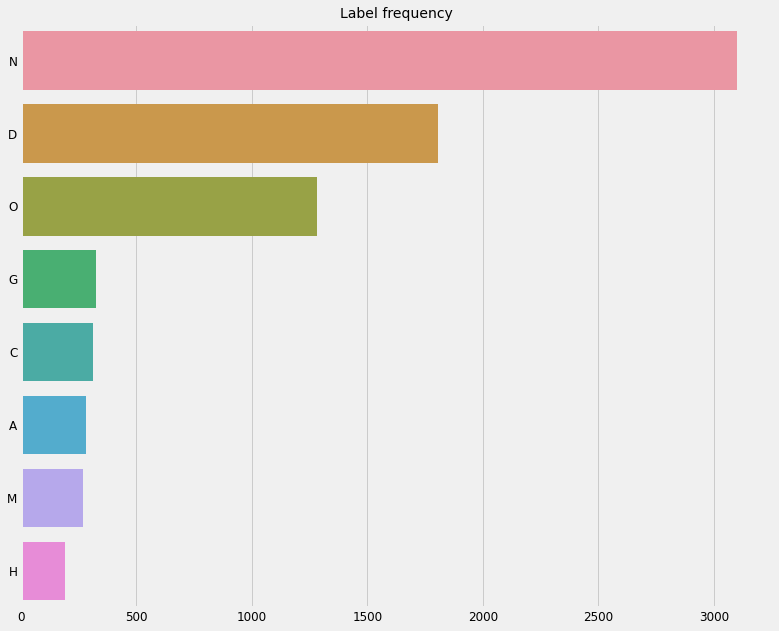

In [62]:
# Get label frequencies in descending order
label_freq = new_df['label'].explode().value_counts().sort_values(ascending=False)

# Bar plot
style.use("fivethirtyeight")
plt.figure(figsize=(12,10))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Split train and validation data

In [75]:
x_train, x_val, y_train, y_val = train_test_split(new_df['filename'], new_df['label'], test_size=0.2, random_state=44)
print("Number of posters for training: ", len(x_train))
print("Number of posters for validation: ", len(x_val))

Number of posters for training:  5600
Number of posters for validation:  1400


In [66]:
x_train

2817     3440_left.jpg
4718    1302_right.jpg
1598     2137_left.jpg
3969     470_right.jpg
5234    2357_right.jpg
             ...      
571       572_left.jpg
1197     1274_left.jpg
2801     3424_left.jpg
3491     4678_left.jpg
5908    3031_right.jpg
Name: filename, Length: 5600, dtype: object

In [76]:
# Create a list containing path to locate train and validation images

x_train = [os.path.join('/content/files/ODIR-5K/Training Images', str(f)) for f in x_train]
x_val = [os.path.join('/content/files/ODIR-5K/Training Images', str(f)) for f in x_val]
x_train[:3]

['/content/files/ODIR-5K/Training Images/3440_left.jpg',
 '/content/files/ODIR-5K/Training Images/1302_right.jpg',
 '/content/files/ODIR-5K/Training Images/2137_left.jpg']

In [77]:
# Convert to a list of list

y_train = list(y_train)
y_val = list(y_val)
y_train[:3]

[['N'], ['G', 'D'], ['C']]

# Image example

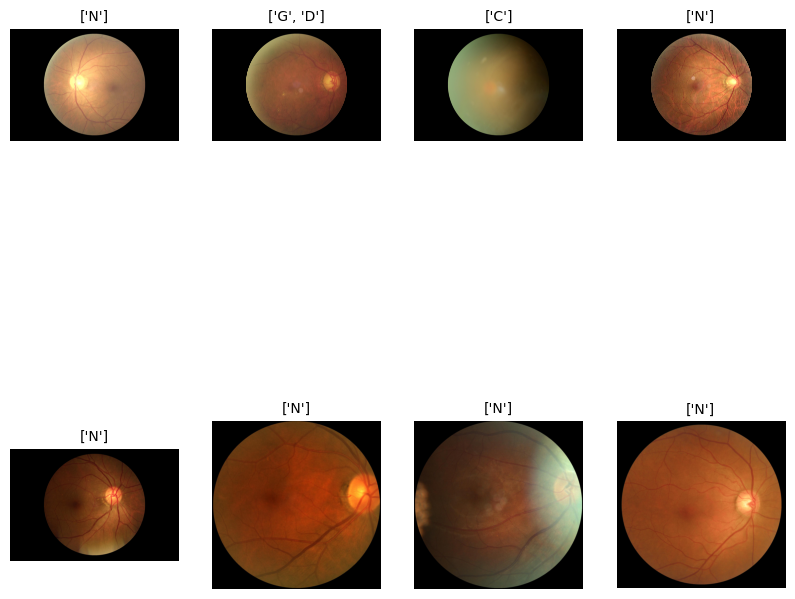

In [81]:
nobs = 8 # Maximum number of images to display
ncols = 4 # Number of columns in display
nrows = nobs//ncols # Number of rows in display

style.use("default")
plt.figure(figsize=(10, 10))
for i in range(nrows*ncols):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(Image.open(x_train[i]))
    plt.title(y_train[i], size=10)
    plt.axis('off')

# Label encoding

In [82]:
# Fit the multi-label binarizer on the training set
print("Labels:")
mlb.fit(y_train)

# Loop over all labels and show them
N_LABELS = len(mlb.classes_)
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i, label))

Labels:
0. A
1. C
2. D
3. G
4. H
5. M
6. N
7. O


In [0]:
# transform the targets of the training and test sets
y_train_bin = mlb.transform(y_train)
y_val_bin = mlb.transform(y_val)

In [84]:
# Print example of movie posters and their binary targets
for i in range(3):
    print(x_train[i], y_train_bin[i])

/content/files/ODIR-5K/Training Images/3440_left.jpg [0 0 0 0 0 0 1 0]
/content/files/ODIR-5K/Training Images/1302_right.jpg [0 0 1 1 0 0 0 0]
/content/files/ODIR-5K/Training Images/2137_left.jpg [0 1 0 0 0 0 0 0]


# Input pipeline

In [0]:
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model

In [0]:
def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [0]:
BATCH_SIZE = 256 # Big enough to measure an F1-score
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations

In [0]:
def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [0]:
train_ds = create_dataset(x_train, y_train_bin)
val_ds = create_dataset(x_val, y_val_bin)

In [94]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (256, 224, 224, 3)
Shape of labels array: (256, 8)


# Model buiding (transfer learning)

In [0]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

In [0]:
feature_extractor_layer.trainable = False

In [100]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(1024, activation='relu', name='hidden_layer'),
    tf.keras.layers.Dense(N_LABELS, activation='sigmoid', name='output')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
hidden_layer (Dense)         (None, 1024)              1311744   
_________________________________________________________________
output (Dense)               (None, 8)                 8200      
Total params: 3,577,928
Trainable params: 1,319,944
Non-trainable params: 2,257,984
_________________________________________________________________


In [101]:
for batch in train_ds:
    print(model.predict(batch)[:1])
    break

[[0.38502413 0.23570514 0.2914173  0.83298707 0.6485856  0.47883555
  0.44150516 0.795009  ]]


# Model training and evaluation

In [0]:
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [0]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [0]:
LR = 1e-5 # Keep it small when transfer learning
EPOCHS = 30

In [0]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss=macro_soft_f1,
  metrics=[macro_f1])

In [112]:
start = time()
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds)

Epoch 1/30
22/22 [==============================] - 280s 13s/step - loss: 0.8174 - macro_f1: 0.1861 - val_loss: 0.8032 - val_macro_f1: 0.2168
Epoch 2/30
22/22 [==============================] - 206s 9s/step - loss: 0.7975 - macro_f1: 0.2318 - val_loss: 0.7904 - val_macro_f1: 0.2542
Epoch 3/30
22/22 [==============================] - 206s 9s/step - loss: 0.7845 - macro_f1: 0.2976 - val_loss: 0.7787 - val_macro_f1: 0.3159
Epoch 4/30
22/22 [==============================] - 206s 9s/step - loss: 0.7677 - macro_f1: 0.3459 - val_loss: 0.7610 - val_macro_f1: 0.3379
Epoch 5/30
22/22 [==============================] - 206s 9s/step - loss: 0.7434 - macro_f1: 0.3503 - val_loss: 0.7374 - val_macro_f1: 0.3387
Epoch 6/30
22/22 [==============================] - 206s 9s/step - loss: 0.7187 - macro_f1: 0.3519 - val_loss: 0.7167 - val_macro_f1: 0.3505
Epoch 7/30
22/22 [==============================] - 206s 9s/step - loss: 0.7009 - macro_f1: 0.3567 - val_loss: 0.7000 - val_macro_f1: 0.3663
Epoch 8/30
2

NameError: ignored

In [0]:
def print_time(t):
    """Function that converts time period in seconds into %h:%m:%s expression.
    Args:
        t (int): time period in seconds
    Returns:
        s (string): time period formatted
    """
    h = t//3600
    m = (t%3600)//60
    s = (t%3600)%60
    return '%dh:%dm:%ds'%(h,m,s)

In [123]:
print('\nTraining took {}'.format(print_time(time()-start)))

TypeError: ignored

In [0]:
def learning_curves(history):
    """Plot the learning curves of loss and macro f1 score 
    for the training and validation datasets.
    
    Args:
        history: history callback of fitting a tensorflow keras model 
    """
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    macro_f1 = history.history['macro_f1']
    val_macro_f1 = history.history['val_macro_f1']
    
    epochs = len(loss)

    style.use("bmh")
    plt.figure(figsize=(8, 8))

    plt.subplot(2, 1, 1)
    plt.plot(range(1, epochs+1), loss, label='Training Loss')
    plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    plt.subplot(2, 1, 2)
    plt.plot(range(1, epochs+1), macro_f1, label='Training Macro F1-score')
    plt.plot(range(1, epochs+1), val_macro_f1, label='Validation Macro F1-score')
    plt.legend(loc='lower right')
    plt.ylabel('Macro F1-score')
    plt.title('Training and Validation Macro F1-score')
    plt.xlabel('epoch')

    plt.show()
    
    return loss, val_loss, macro_f1, val_macro_f1

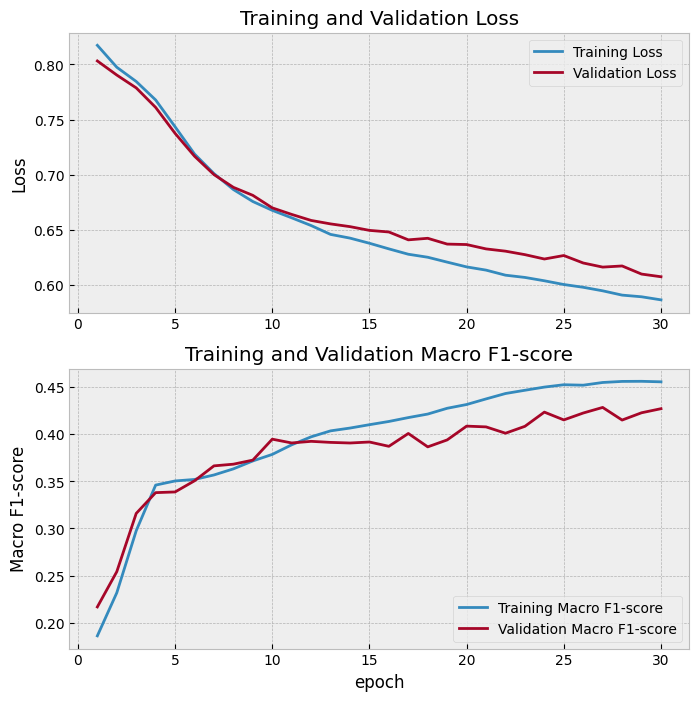

In [125]:
losses, val_losses, macro_f1s, val_macro_f1s = learning_curves(history)

# Show prediction

In [0]:
def show_prediction(filename, df, model):
    
    # Get movie info
    im = new_df.loc[new_df['filename']==filename]['filename'].iloc[0]
    lbl = new_df.loc[new_df['filename']==filename]['label'].iloc[0]
    img_path = os.path.join('/content/files/ODIR-5K/Training Images', str(im))

    # Read and prepare image
    img = image.load_img(img_path, target_size=(IMG_SIZE,IMG_SIZE,CHANNELS))
    img = image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)

    # Generate prediction
    prediction = (model.predict(img) > 0.5).astype('int')
    prediction = pd.Series(prediction[0])
    prediction.index = mlb.classes_
    prediction = prediction[prediction==1].index.values

    # Dispaly image with prediction
    style.use('default')
    plt.figure(figsize=(8,4))
    plt.imshow(Image.open(img_path))
    plt.title('\n\n{}\n\nLabel\n{}\n\nPrediction\n{}\n'.format(im, lbl, list(prediction)), fontsize=9)
    plt.show()

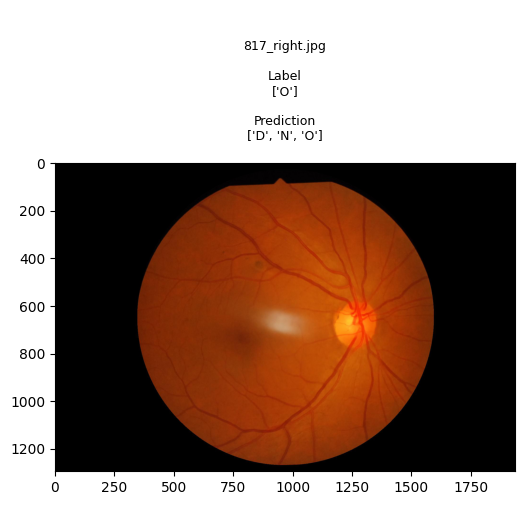

In [137]:
sample = random.choices(new_df.filename.values.tolist(), k=1)

for t in sample:
    show_prediction(t, new_df, model)